# GLOBAL TRANSACTION MODEL

This notebook is intended to build the global transaction model
 - #### <b>Task : </b> recognise the patterns of all the frauds in the past
 - #### <b>Dataset : </b> BankSim data
 - #### <b> Model : </b> TBD

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, average_precision_score, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
computation = 'cloud'

In [4]:
if computation == 'local' :
    data_path = '../data/transaction_fraud/'
else :
  from google.colab import drive
  drive.mount('/content/drive')
  data_path = '/content/drive/MyDrive/uco_fraud_detector/data/transaction_fraud/'
print(os.listdir(data_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['bs140513_032310.csv', 'bsNET140513_032310.csv']


In [5]:
df = pd.read_csv(data_path + os.listdir(data_path)[0])
samples = df.shape[0]
print("No. of samples", samples)
df.info()

No. of samples 594643
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [6]:
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


#### 1. check for missing values

In [7]:
df.isna().any()

,0
step,False
customer,False
age,False
gender,False
zipcodeOri,False
merchant,False
zipMerchant,False
category,False
amount,False
fraud,False


Therefore, no missing values. So, we move forward withe data engineering \
#### 2. fix the strings with quotation on either side

In [8]:
for c in df.columns :
    if df[c].dtype==object :
        df[c] = df[c].replace("'","", regex = True)
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0


## Exploratory Data Analysis

there are a very few questions that need to be answered from the data :
 - number of bank accounts that we are dealing with ?
 - spread of the value of the amount cloumn ?
 - proportion of valid / fraud Transactions
 - dependency of each features on fraudulent transaction ?

In [9]:
print("Number of Bank Accounts" , df['customer'].nunique())

Number of Bank Accounts 4112


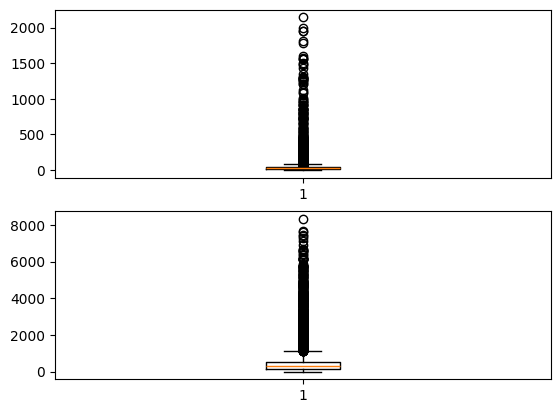

In [10]:
plt.subplot(211)
plt.boxplot(df[df['fraud']==0]['amount'])
plt.subplot(212)
plt.boxplot(df[df['fraud']==1]['amount'])
plt.show()

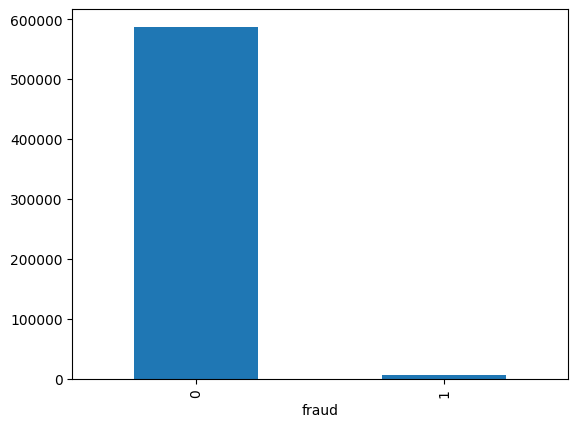

fraud percentage :  1.211%


In [11]:
df['fraud'].value_counts().plot.bar()
plt.show()
count_fraud = df[df['fraud']==1].shape[0]
fraud_percentage = (count_fraud*100/samples)
print( f"fraud percentage :  {fraud_percentage:.3f}%")

the fraud percentage is too low for the model to recognise pattern with respect to the valid percentage. \
This indicates that a certain data augmentation process must be employed.


Now, we need to check the dependencies of each feature.\
before that we need to change the categorical features.
#### 3. lableing data

In [12]:
df.nunique()

,0
step,180
customer,4112
age,8
gender,4
zipcodeOri,1
merchant,50
zipMerchant,1
category,15
amount,23767
fraud,2


zipcode and zip merchant data feature has only one value , there fore its correlation with the fraud column will be negligible. thus, we can drop it for faster data processing.

In [13]:
df = df.drop(['zipcodeOri' , 'zipMerchant'], axis=1)
df.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0


In [14]:
copy_df = df.copy()
label_encoders ={}
#frequency encoding the account details
for c in ['customer' , 'merchant'] :
    frequency = df[c].value_counts()
    df[c] = df[c].apply(lambda x : frequency[x])

#lable encoding ctegorical features
categorical_features = ['age' , 'gender' , 'category']
for c in categorical_features :
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c])
    label_encoders[f'{c}'] = le

print(df.head())
label_encoders

   step  customer  age  gender  merchant  category  amount  fraud
0     0       167    4       2    205426        12    4.55      0
1     0       169    2       2    205426        12   39.68      0
2     0        65    4       1    299693        12   26.89      0
3     0       171    3       2    205426        12   17.25      0
4     0       145    5       2    205426        12   35.72      0


{'age': LabelEncoder(), 'gender': LabelEncoder(), 'category': LabelEncoder()}

checking dependencies

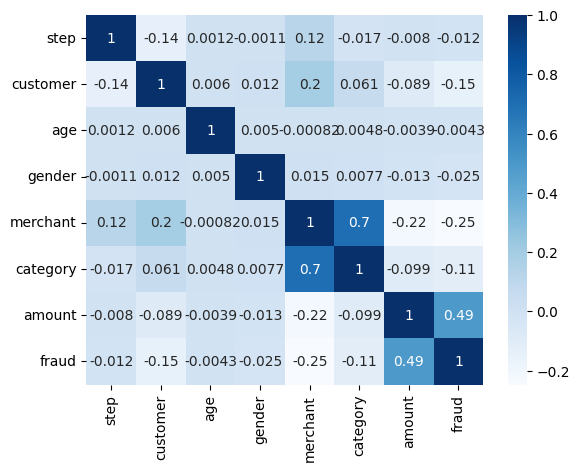

In [16]:
sns.heatmap(df.corr(), annot=True,cmap='Blues')
plt.show()

In [ ]:
X = df.drop('fraud', axis = 1)
Y = df['fraud']
input_features = X.columns
data_preprocessing_info ={
    'step' : 'time from first transaction (int)(counter)',
    'customer' : 'frequency encoded account',
    'age' : 'label encoded (label encoder stored : le.transform(X[col])',
    'gender' : 'label encoded (label encoder stored : le.transform(X[col])',
    'merchant' : 'frequency encoded merchant account',
    'category' : 'label encoded (label encoder stored : le.transform(X[col])',
    'amount' : '',

}
print(X.head())
print(Y.head())

   step  customer  age  gender  merchant  category  amount
0     0       167    4       2    205426        12    4.55
1     0       169    2       2    205426        12   39.68
2     0        65    4       1    299693        12   26.89
3     0       171    3       2    205426        12   17.25
4     0       145    5       2    205426        12   35.72
0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


## Dimensionality Reduction (PCA)

In [ ]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df[:2,:]

array([[-1.86053184,  0.34041972,  0.73797533,  1.09064295, -0.1822711 ,
         0.33140542, -0.29927573, -0.11070912],
       [-1.86053184,  0.41038486, -0.75916184,  1.09064295, -0.1822711 ,
         0.33140542,  0.01606661, -0.11070912]])

In [ ]:
pca  = PCA(n_components = 8)
pca.fit(scaled_df)
print(pca.explained_variance_ratio_)

[0.25208542 0.15778136 0.13992907 0.12550146 0.12431942 0.10475934
 0.06324677 0.03237718]


therefore, all features are relevent for the detection \
<b> as seen earlier the dataset is imbalanced, as very few number of fraudulent transaction is used \
therefore, we must use a oversampling technique to balance the dataset, \
here we will use SMOTE (Synthetic Minority OverSampling) \
before that we have to split the dataset because we should not apply smote on the testing dataset</b>

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 16)

In [ ]:
def evaluate_model(model,
                   model_name,
                   X_train,
                   Y_train,
                   X_test,
                   Y_test) :
    model.fit(X_train, Y_train)
    y_cap = model.predict(X_test)
    print(f'Evaluation_for {model_name}: ')
    print(classification_report(Y_test, y_cap))
    conf_mat = confusion_matrix(Y_test, y_cap)
    plt.figure(figsize = (5,5))
    sns.heatmap(conf_mat, annot = True,fmt = 'd', cmap = 'plasma')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('y_cap')
    plt.ylabel('y_test')
    plt.show()

    #ROC curve and the area under curve
    y_score = model.predict_proba(X_test)[:,1]
    false_pos_rate , true_pos_rate, thr = roc_curve(Y_test, y_score)
    roc_auc = auc(false_pos_rate , true_pos_rate)

    plt.figure(figsize = (7,5))
    plt.plot(false_pos_rate, true_pos_rate, label = f'ROC Curve, area = {roc_auc:.3f}')
    plt.plot([0,1] , [0,1] , linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

    #Precision-Recall curve Nad AUC
    precision, recall, thresholds = precision_recall_curve(Y_test, y_score)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(7, 5))
    plt.plot(recall, precision, label=f'PR Curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.legend(loc='best')
    plt.show()

## SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 16)
X_train_smote , Y_train_smote = smote.fit_resample(X_train,Y_train)

## Random Forest

Evaluation_for Random_forest Classifier: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117502
           1       0.91      0.80      0.85      1427

    accuracy                           1.00    118929
   macro avg       0.95      0.90      0.93    118929
weighted avg       1.00      1.00      1.00    118929



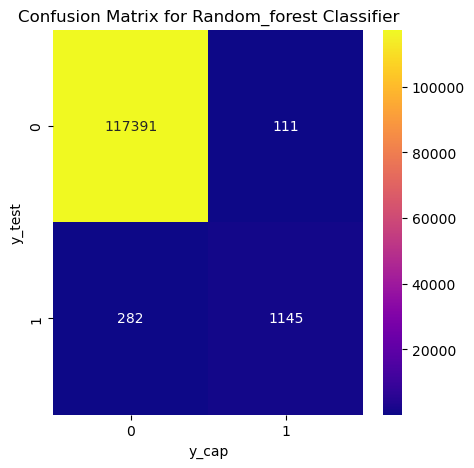

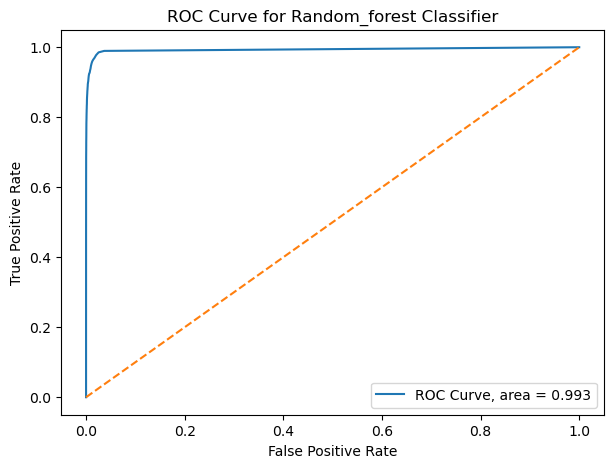

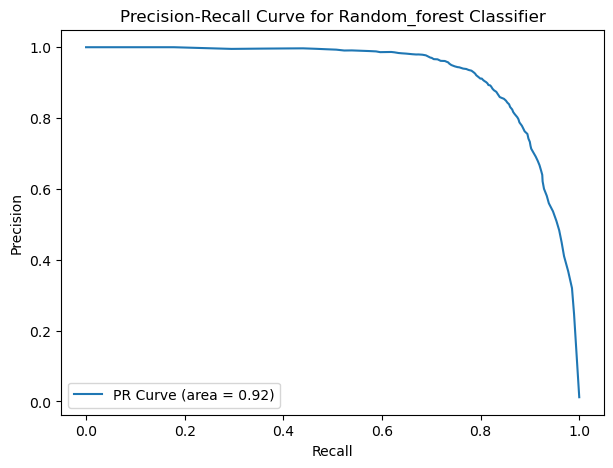

In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()
evaluate_model(random_forest, "Random_forest Classifier", X_train, Y_train,X_test, Y_test)

## Balanced Random Forest

Evaluation_for Balanced Random Forest : 
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    117502
           1       0.30      0.99      0.46      1427

    accuracy                           0.97    118929
   macro avg       0.65      0.98      0.72    118929
weighted avg       0.99      0.97      0.98    118929



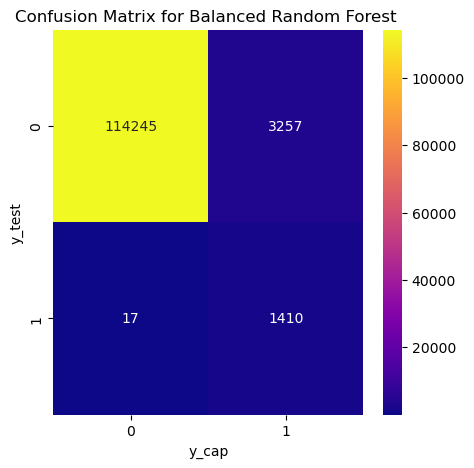

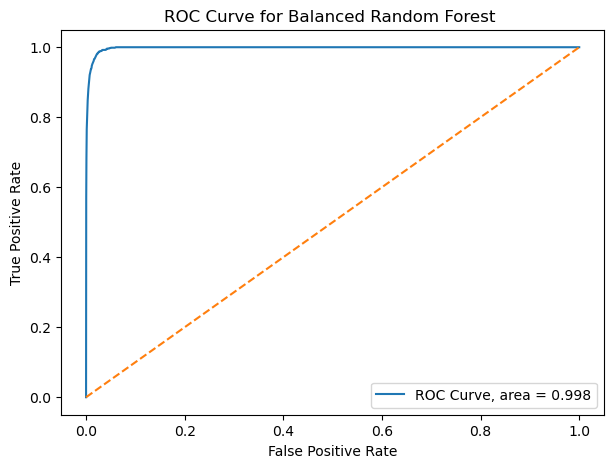

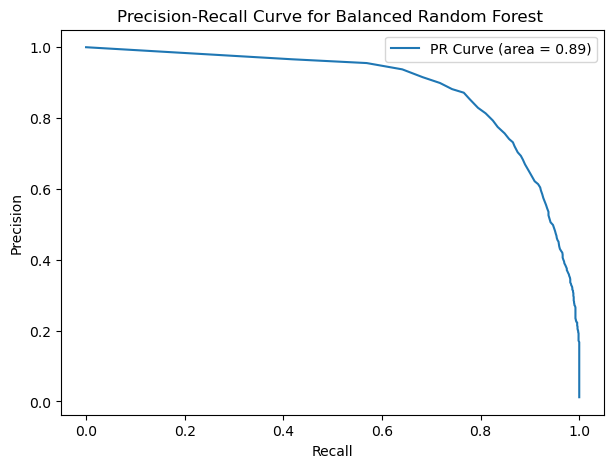

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(n_estimators = 150, random_state = 16)
evaluate_model(brf,"Balanced Random Forest ", X_train, Y_train, X_test , Y_test)

## XGBoost

Evaluation_for XGBoost: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117502
           1       0.89      0.81      0.85      1427

    accuracy                           1.00    118929
   macro avg       0.94      0.90      0.92    118929
weighted avg       1.00      1.00      1.00    118929



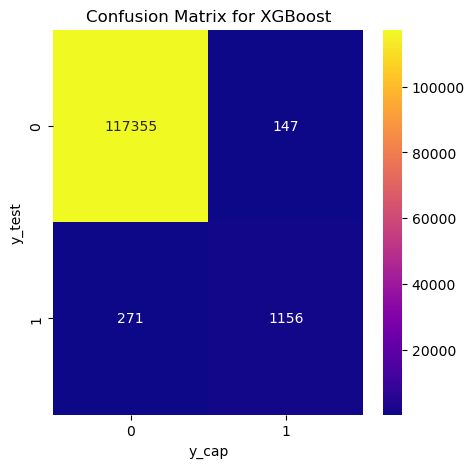

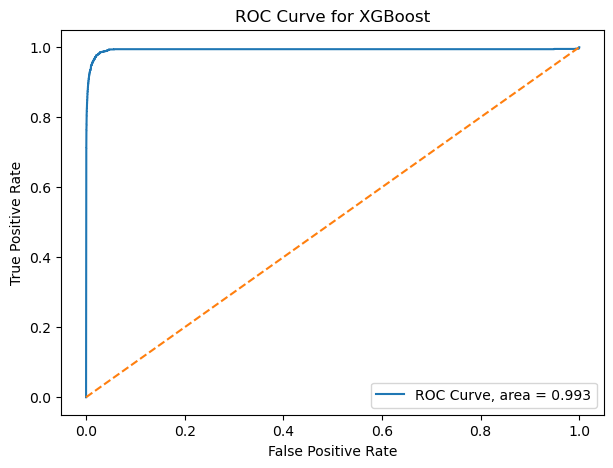

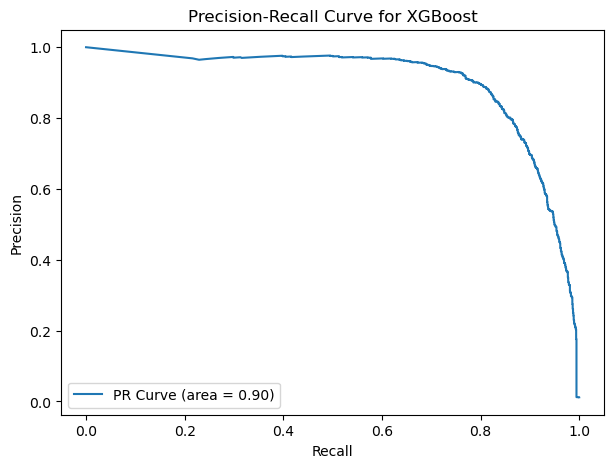

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
evaluate_model(xgb, "XGBoost", X_train,Y_train,X_test,Y_test)

## Adaptive Boosting

Evaluation_for AdaBoost: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117502
           1       0.88      0.67      0.76      1427

    accuracy                           0.99    118929
   macro avg       0.94      0.83      0.88    118929
weighted avg       0.99      0.99      0.99    118929



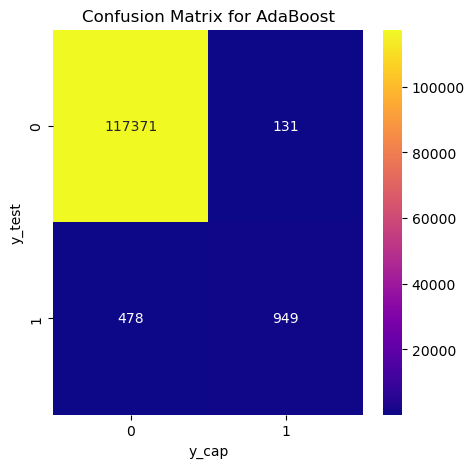

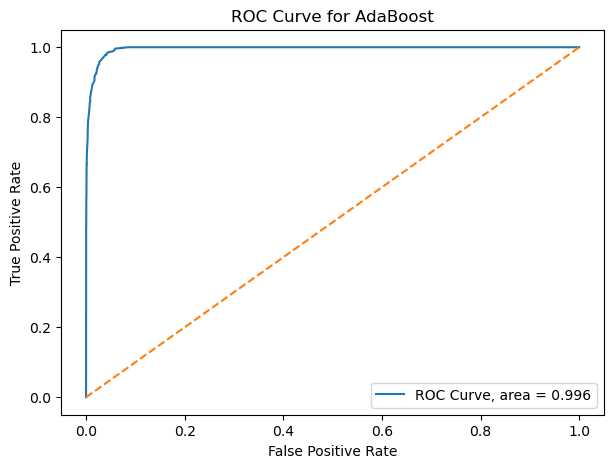

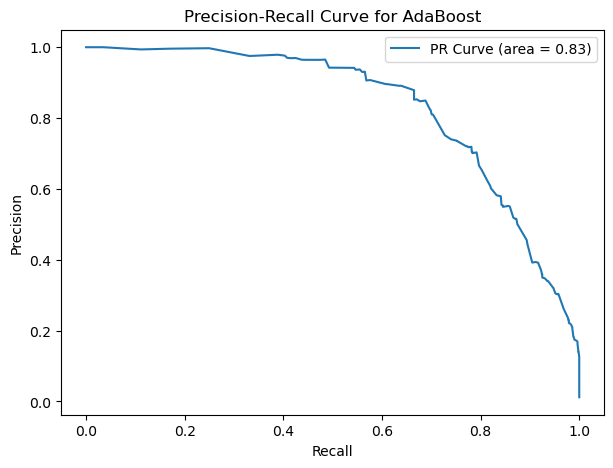

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(random_state=42)
evaluate_model(ada, "AdaBoost",  X_train, Y_train, X_test, Y_test)

## KNN

therefore, random forest and extreme gradient boosing gives the best results , thus, stacking these two modfels to form an ensemble must give even better results. \
But before that we must find the p[arameters for each of the model taht gives the best results,

## param find for XGBoost

In [ ]:
if computation == 'cloud' :
  from sklearn.model_selection import GridSearchCV, StratifiedKFold
  xgb = XGBClassifier(random_state=16, objective='binary:logistic')
  param_grid = {
      'n_estimators': [100, 200, 300, 400],
      'max_depth': [3, 5, 7],
      'learning_rate': [0.01, 0.05, 0.1],
      'subsample': [0.8, 0.9, 1.0]
  }
  cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=16)
  grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                            cv=cv, n_jobs=-1, verbose=1, scoring='recall')
  grid_search.fit(X_train, Y_train)
  print("Best parameters : ", grid_search.best_params_)
  best_xgb_model = grid_search.best_estimator_

therefore, the best XGBoost model will have parameters : \
Best parameters :  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

## param find for Random Forest

In [ ]:
if computation == 'cloud' :
  from sklearn.model_selection import RandomizedSearchCV
  rf = RandomForestClassifier(random_state=16)
  param_dist = {
      'n_estimators': np.random.randint(100, 500, size=1),
      'max_depth': np.random.randint(5, 15, size=1),
      'min_samples_split': np.random.randint(2, 20, size=1),
      'min_samples_leaf': np.random.randint(1, 10, size=1)
  }
  cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=16)
  random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                    n_iter=100, cv=cv, n_jobs=-1, verbose=1,
                                    random_state=16, scoring='recall')
  random_search.fit(X_train, Y_train)
  print("Best parameters found: ", random_search.best_params_)
  best_rf_model = random_search.best_estimator_

Therefore the best parameters for random forest are : \
Best parameters found:  {'n_estimators': 100, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_depth': 12}


## Ensemble

Evaluation_for Ensemble (XGB + RF): 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117502
           1       0.95      0.75      0.84      1427

    accuracy                           1.00    118929
   macro avg       0.97      0.88      0.92    118929
weighted avg       1.00      1.00      1.00    118929



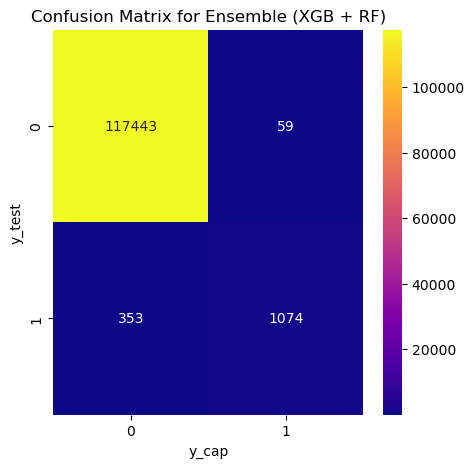

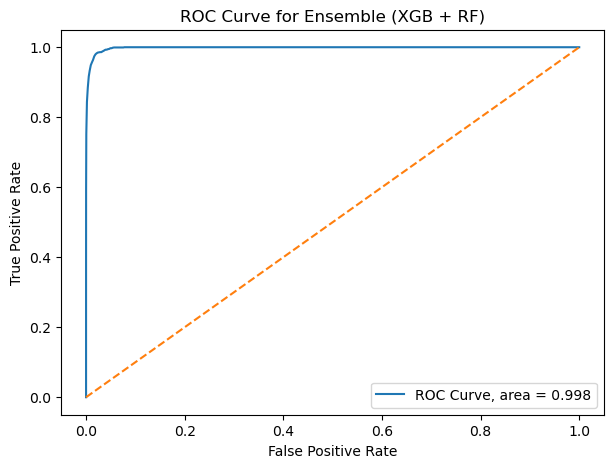

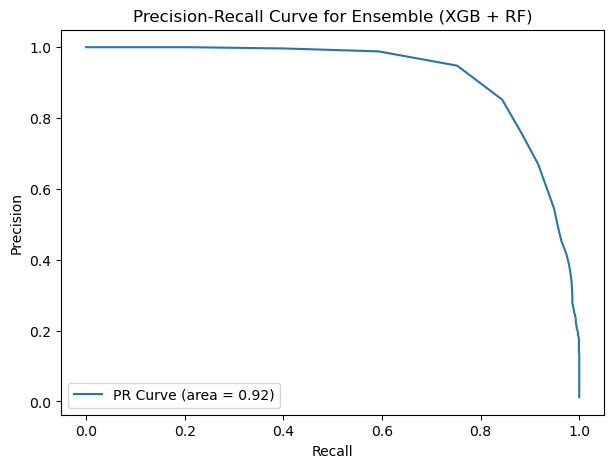

In [ ]:
from sklearn.ensemble import StackingClassifier

base_model = RandomForestClassifier(random_state = 16,
                                    max_depth = 14,
                                    min_samples_leaf = 1,
                                    min_samples_split = 16,
                                    n_estimators = 389)
meta_model = XGBClassifier(eval_metric = 'aucpr',
                           random_state = 16,
                           objective = 'binary:logistic',
                           learning_rate = 0.1,
                           max_depth = 7,
                           n_estimators = 400,
                           subsample = 0.8)

stacked_model = StackingClassifier(estimators = [('rf',base_model)],
                                   final_estimator = meta_model)
evaluate_model(stacked_model,
               'Ensemble (XGB + RF)',
               X_train,
               Y_train,
               X_test,
               Y_test)

#### Therefore, these are the results of the esemble and this model would be used to claculate the first part of the pipeline

In [ ]:
print(label_encoders)
print(categorical_features)
print(data_preprocessing_info)
print(input_features)
stacked_model.input_features = input_features
stacked_model.categorical_features = categorical_features
stacked_model.data_preprocessing_info = data_preprocessing_info
stacked_model.label_encoders = label_encoders
stacked_model.name = 'Ensemble : XGBoost + Random Forest'

{'age': LabelEncoder(), 'gender': LabelEncoder(), 'category': LabelEncoder()}
['age', 'gender', 'category']
{'step': 'time from first transaction (int)(counter)', 'customer': 'frequency encoded account', 'age': 'label encoded (label encoder stored : le.transform(X[col])', 'gender': 'label encoded (label encoder stored : le.transform(X[col])', 'merchant': 'frequency encoded merchant account', 'category': 'label encoded (label encoder stored : le.transform(X[col])', 'amount': ''}
Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount'], dtype='object')


In [ ]:
import pickle
model_save_path = '../models/globalmodel'
file = open(model_save_path , 'wb')
pickle.dump(stacked_model , file)
print(f'MODEL_SAVED at path {model_save_path}')

MODEL_SAVED at path ../models/globalmodel
